### Let's begin Cora dataset trip from a simple example supported by PYGod

**Hear,we push the process like below**

1. load Cora datasets using torch_geometric.datasets.Planetoid

2. generate the contextual and structure outliers using Pyg tools

3. create a classical GNN model and train for the binary classification task

4. inference from the trained model under a transductive manner. 

### First, Load the Cora datasets

In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T  

data = Planetoid('../data/Cora','Cora',transform = None)[0]

F:\anaconda\envs\pygod2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data.edge_index[0]
data.num_node_features

1433

In [3]:
from torch_geometric.utils import degree
degree(data.edge_index[0],data.num_nodes)

tensor([3., 3., 5.,  ..., 1., 4., 4.])

In [4]:
import pandas
import torch

y_pan = pandas.Series(data.y)
min_class = y_pan.value_counts().argmin()
torch.tensor(y_pan.apply(lambda x: 1 if x == min_class else 0).to_numpy(),dtype = torch.long)

tensor([0, 0, 0,  ..., 0, 0, 0])

### Second, generater the synthesis anomaly by pyg tools

In [5]:
from sklearn.model_selection import train_test_split

train_mask, test_mask = train_test_split(list(range(data.num_node_features)),train_size=0.6)
val_mask, test_mask = train_test_split(test_mask,train_size=0.6)

In [6]:
data, yc = gen_contextual_outliers(data,n=100,k=50)

NameError: name 'gen_contextual_outliers' is not defined

In [ ]:
data.y

In [7]:
import torch
from pygod.generator import gen_contextual_outliers,gen_structural_outliers

data, yc = gen_contextual_outliers(data,n=100,k=50)
data, ys = gen_structural_outliers(data,m=10,n=10)

data.y = yc.logical_or(ys)

In [8]:
from pygod.models import DOMINANT

model = DOMINANT()
model.act = torch.nn.functional.leaky_relu
model.fit(data)

model.decision_function(data).max()
data.y.eq(torch.tensor(model.predict(data))).sum()/len(data.y)

tensor(0.9021)

### Practice for Cora binary classication using GCN by means of PYG 

In [9]:
import torch_geometric
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

cora_dataset = Planetoid('./data/Cora',"Cora",transform=T.NormalizeFeatures())[0]

import torch
from pygod.generator import gen_contextual_outliers,gen_structural_outliers

cora_dataset, yc = gen_contextual_outliers(cora_dataset,n=100,k=50)
cora_dataset, ys = gen_structural_outliers(cora_dataset,m=10,n=10)

cora_dataset.y = yc.logical_or(ys).to(torch.long)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Simplenet(nn.Module):
    
    def __init__(self,in_feat,h_feat,num_classes):
        super(Simplenet,self).__init__()

        self.conv1 = GCNConv(in_feat,h_feat)
        self.conv2 = GCNConv(h_feat,num_classes)

    def forward(self,data):
        feature, edges = data.x,data.edge_index
        feature = F.relu(self.conv1(feature,edges))
        feature = F.dropout(feature,training = self.training)
        feature = self.conv2(feature,edges)
        return feature

num_classes = cora_dataset.y.unique().size()[0]
model = Simplenet(cora_dataset.num_features,16,num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Simplenet(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 2)
)

### Training process

In [11]:
model.train()
epochs = 200
lr = 1e-2
# weight decay is similar as L2 normalize, what different is weight decay matter in update strategy.
optimizer = torch.optim.Adam(model.parameters(),lr = lr,weight_decay=1e-3)

cora_dataset.x = cora_dataset.x.to(device)
cora_dataset.edge_index = cora_dataset.edge_index.to(device)
cora_dataset.y = cora_dataset.y.to(device)
for i in range(epochs):
    model.zero_grad()
    logit = model(cora_dataset)
    loss = F.cross_entropy(logit[cora_dataset.train_mask],cora_dataset.y[cora_dataset.train_mask])
    loss.backward()
    optimizer.step()
    print (f"epoch {i}/{epochs}: loss {loss};")


epoch 0/200: loss 0.6893231272697449;
epoch 1/200: loss 0.6408898234367371;
epoch 2/200: loss 0.5857827067375183;
epoch 3/200: loss 0.5336357951164246;
epoch 4/200: loss 0.48117560148239136;
epoch 5/200: loss 0.44403642416000366;
epoch 6/200: loss 0.3986646234989166;
epoch 7/200: loss 0.35421186685562134;
epoch 8/200: loss 0.3231336772441864;
epoch 9/200: loss 0.29867130517959595;
epoch 10/200: loss 0.2797528803348541;
epoch 11/200: loss 0.25842171907424927;
epoch 12/200: loss 0.24012736976146698;
epoch 13/200: loss 0.22958038747310638;
epoch 14/200: loss 0.23098653554916382;
epoch 15/200: loss 0.21935051679611206;
epoch 16/200: loss 0.20875413715839386;
epoch 17/200: loss 0.21216996014118195;
epoch 18/200: loss 0.20706915855407715;
epoch 19/200: loss 0.20212964713573456;
epoch 20/200: loss 0.21409916877746582;
epoch 21/200: loss 0.21310937404632568;
epoch 22/200: loss 0.20550285279750824;
epoch 23/200: loss 0.20233143866062164;
epoch 24/200: loss 0.20953412353992462;
epoch 25/200: los

In [12]:
import torch
model.eval()

logits = model(cora_dataset)
probs = F.log_softmax(logits,dim=1)
y_hat = probs.max(1)[1][cora_dataset.test_mask]
correct_rate = cora_dataset.y[cora_dataset.test_mask].eq(y_hat).sum()/cora_dataset.test_mask.sum()*100
print (f"Correct rate is {correct_rate}%")

Correct rate is 92.60000610351562%


### Conlusion: Specify a binary anomaly task:

1. First, using tradition GCN network shows a less competitive, even not far from a random selection.

2. Second, with a test mask (1400 node) to train, we get a 100% precision and low F1 score. Even though, auc runs to 99% is amazing.

In [13]:
# 200/2300
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_curve

pred = y_hat.cpu()
target = cora_dataset.y[cora_dataset.test_mask].cpu()

print (accuracy_score(target, pred))
print (precision_score(target, pred))
print (recall_score(target, pred))

print (f1_score(target, pred))

print (roc_auc_score(target, F.softmax(logits,dim=1)[cora_dataset.test_mask].cpu().detach().numpy()[:,1]))
print (roc_curve(target, probs[cora_dataset.test_mask].cpu().detach().numpy()[:,0]))

print (confusion_matrix(target, pred))

0.926
0.0
0.0
0.0
0.4428667328235363
(array([0.        , 0.00107991, 0.00215983, 0.00215983, 0.01727862,
       0.01727862, 0.02159827, 0.02159827, 0.03023758, 0.03023758,
       0.03779698, 0.03779698, 0.04859611, 0.04859611, 0.05723542,
       0.05831533, 0.06047516, 0.06047516, 0.07019438, 0.07019438,
       0.09179266, 0.09179266, 0.11987041, 0.11987041, 0.12203024,
       0.12203024, 0.12526998, 0.12526998, 0.12634989, 0.12634989,
       0.13390929, 0.13390929, 0.14362851, 0.14362851, 0.15442765,
       0.15442765, 0.16198704, 0.16198704, 0.16306695, 0.16306695,
       0.16954644, 0.16954644, 0.19114471, 0.19114471, 0.19978402,
       0.19978402, 0.20194384, 0.20194384, 0.20302376, 0.20518359,
       0.2062635 , 0.2062635 , 0.21274298, 0.21274298, 0.21598272,
       0.21598272, 0.22678186, 0.22678186, 0.24082073, 0.24082073,
       0.24190065, 0.24190065, 0.24298056, 0.24298056, 0.2699784 ,
       0.2699784 , 0.27429806, 0.27429806, 0.31965443, 0.32181425,
       0.33261339, 0.332

F:\anaconda\envs\pygod2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


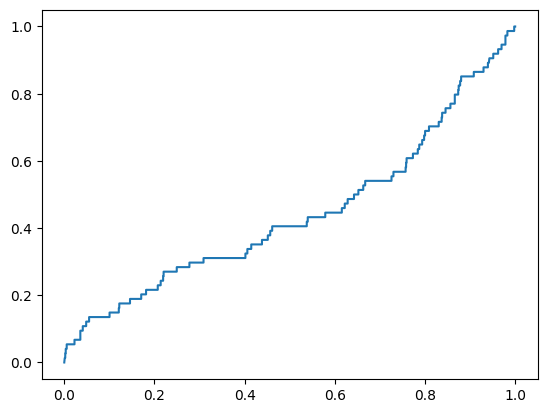

In [14]:
import matplotlib.pyplot as plt

x, y, _ = roc_curve(target, probs[cora_dataset.test_mask].cpu().detach().numpy()[:,1])

plt.plot(x,y)
plt.show()